Скачать датасет по транзакциям по следующей ссылке: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605

Скачать датасет, разделенный на train, valid, test: https://drive.google.com/file/d/17LCDtr60TU3E4GnGuQlzDp6CFghL16_M/view?usp=sharing 

1. Решаем задачу бинарной классификации: является ли клиент фродовым. Транзакции для каждого клиента имеют таргет 'Is Fraud?' и он будет одинкаовым для каждой транзакции клиента.
2. Необходимо провести feature engineering
3. Выбрать подходящую архитектуру нейронной сети.
4. Обучить сеть
5. Показать графики обучения и точности модели

In [1]:
print('Версии используемых библиотек')
import numpy as np
print('numpy', np.__version__)
import pandas as pd
print('pandas', pd.__version__)

import seaborn as sns
print('seaborn', sns.__version__)

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')
print('matplotlib', matplotlib.__version__)

import random

import torch

import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
print('torch', torch.__version__)

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import sklearn
print('sklearn', sklearn.__version__)


import IPython
print('IPython', IPython.__version__)
from IPython.display import clear_output
from collections import Counter
import re


USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

Версии используемых библиотек
numpy 1.19.5
pandas 1.1.0
seaborn 0.10.1
matplotlib 3.3.0
torch 1.8.1+cu101
sklearn 0.23.2
IPython 7.17.0


In [2]:
import pickle

In [2]:
data = pd.read_csv('./data/card_transaction.v1.csv')

In [3]:
data.columns.values

array(['User', 'Card', 'Year', 'Month', 'Day', 'Time', 'Amount',
       'Use Chip', 'Merchant Name', 'Merchant City', 'Merchant State',
       'Zip', 'MCC', 'Errors?', 'Is Fraud?'], dtype=object)

In [4]:
data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No


In [2]:
with open('./data/transactions_train_valid_test_splits.pickle', 'rb') as f:
    data = pickle.load(f)
train_data = data['train']
valid_data = data['valid']
test_data = data['test']

del data

In [5]:
len(train_data), len(valid_data), len(test_data)

(17397216, 3412698, 3576986)

In [6]:
len(train_data['User'].unique()), len(valid_data['User'].unique()), len(test_data['User'].unique())

(1400, 300, 300)

In [7]:
np.intersect1d(train_data['User'].unique(), valid_data['User'].unique())

array([], dtype=int64)

In [8]:
np.intersect1d(train_data['User'].unique(), test_data['User'].unique())

array([], dtype=int64)

In [9]:
np.intersect1d(valid_data['User'].unique(), test_data['User'].unique())

array([], dtype=int64)

## Предобработка данных

Посмотрим на наш датасет

In [9]:
train_data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,IsFraud_target
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,1
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,1
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No,0
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,-5162038175624867091,Merrimack,NH,3054.0,5541,NaN,No,0
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No,0
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,2500998799892805156,Merrimack,NH,3054.0,4121,NaN,No,0


In [10]:
train_data[train_data['IsFraud_target'] == 1]

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,IsFraud_target
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,NaN,No,1
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,NaN,No,1
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,NaN,No,1
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,NaN,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24354745,1996,3,2020,2,24,09:19,$61.63,Chip Transaction,-8143822285549234101,Saint Paul,VA,24283.0,7538,NaN,No,1
24354746,1996,3,2020,2,24,11:37,$9.53,Chip Transaction,-5162038175624867091,Wise,VA,24293.0,5541,NaN,No,1
24354747,1996,3,2020,2,25,12:04,$16.48,Swipe Transaction,-2744911404133435018,Maysville,KY,41056.0,5812,NaN,No,1
24354748,1996,3,2020,2,27,06:01,$10.53,Chip Transaction,-245178307025547046,Bellevue,KY,41073.0,5311,NaN,No,1


Что можно сделать в первую очередь?<br><br>
__1)__ Удалить колонки с идентификаторами(Merchant Name), чтобы нейросеть не находила там закономерности<br>
__2)__ Месяц и время можно преобразовать в циклические переменные, например косинус или синус<br>
__3)__ Можно увидеть, что колонка Zip и колонки Merchant City и Merchant State описывают одно и тоже (местоположение клиента/место совершения транзакции), можно оставить только Zip.<br>
__4)__ Заметим, что в колонке Errors очень много одинаковых значений(а именно NaN) и пренебрижимо мало других классов. Возможно эта колонка нам не поможет и ее можно удалить.<br>
__5)__ Перевести Amount в числовой формат (без знака доллара)<br>
__6)__ Посмотрим также на пропуски данных<br>
__7)__ С оставшимися категориальными признаками провести One Hot Encoding/Label Encoding/to Embeddings

In [4]:
# 1)
train_data.drop('Merchant Name',1, inplace = True)
valid_data.drop('Merchant Name',1, inplace = True)
test_data.drop('Merchant Name',1, inplace = True)

In [12]:
train_data

,User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?,IsFraud_target
0,0,0,2002,9,1,06:21,$134.09,Swipe Transaction,La Verne,CA,91750.0,5300,NaN,No,1
1,0,0,2002,9,1,06:42,$38.48,Swipe Transaction,Monterey Park,CA,91754.0,5411,NaN,No,1
2,0,0,2002,9,2,06:22,$120.34,Swipe Transaction,Monterey Park,CA,91754.0,5411,NaN,No,1
3,0,0,2002,9,2,17:45,$128.95,Swipe Transaction,Monterey Park,CA,91754.0,5651,NaN,No,1
4,0,0,2002,9,3,06:23,$104.71,Swipe Transaction,La Verne,CA,91750.0,5912,NaN,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,2,27,22:23,$-54.00,Chip Transaction,Merrimack,NH,3054.0,5541,NaN,No,0
24386896,1999,1,2020,2,27,22:24,$54.00,Chip Transaction,Merrimack,NH,3054.0,5541,NaN,No,0
24386897,1999,1,2020,2,28,07:43,$59.15,Chip Transaction,Merrimack,NH,3054.0,4121,NaN,No,0
24386898,1999,1,2020,2,28,20:10,$43.12,Chip Transaction,Merrimack,NH,3054.0,4121,NaN,No,0


In [5]:
# 2)
from datetime import datetime
# train_data['date'] = train_data['Year'].apply(str).str.cat(train_data['Month'].apply(str), sep ="-").apply(str).str.cat(train_data['Day'].apply(str), sep='-').str.cat(train_data['Time'], sep = ' ')
train_data['Month_cos'] = np.cos(2 * np.pi / 12. * train_data['Month'].values)
valid_data['Month_cos'] = np.cos(2 * np.pi / 12. * valid_data['Month'].values)
test_data['Month_cos'] = np.cos(2 * np.pi / 12. * test_data['Month'].values)

train_data['Month_sin'] = np.sin(2 * np.pi / 12. * train_data['Month'].values)
valid_data['Month_sin'] = np.sin(2 * np.pi / 12. * valid_data['Month'].values)
test_data['Month_sin'] = np.sin(2 * np.pi / 12. * test_data['Month'].values)

train_data['Day_cos'] = np.cos(2 * np.pi / 31. * train_data['Day'].values)
valid_data['Day_cos'] = np.cos(2 * np.pi / 31. * valid_data['Day'].values)
test_data['Day_cos'] = np.cos(2 * np.pi / 31. * test_data['Day'].values)

train_data['Day_sin'] = np.sin(2 * np.pi / 31. * train_data['Day'].values)
valid_data['Day_sin'] = np.sin(2 * np.pi / 31. * valid_data['Day'].values)
test_data['Day_sin'] = np.sin(2 * np.pi / 31. * test_data['Day'].values)

train_data['Time_cos'] = np.cos(2 * np.pi / 1440. * (pd.to_datetime(train_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(train_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))
valid_data['Time_cos'] = np.cos(2 * np.pi / 1440. * (pd.to_datetime(valid_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(valid_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))
test_data['Time_cos'] = np.cos(2 * np.pi / 1440. * (pd.to_datetime(test_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(test_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))

train_data['Time_sin'] = np.sin(2 * np.pi / 1440. * (pd.to_datetime(train_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(train_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))
valid_data['Time_sin'] = np.sin(2 * np.pi / 1440. * (pd.to_datetime(valid_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(valid_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))
test_data['Time_sin'] = np.sin(2 * np.pi / 1440. * (pd.to_datetime(test_data['Time'], format='%H:%M').dt.strftime('%H').astype(int).values * 60 + pd.to_datetime(test_data['Time'], format='%H:%M').dt.strftime('%M').astype(int).values))



In [6]:
train_data.drop(['Month', 'Day','Time'],1, inplace = True)
valid_data.drop(['Month', 'Day','Time'],1, inplace = True)
test_data.drop(['Month', 'Day','Time'],1, inplace = True)

In [9]:
train_data

,User,Card,Year,Amount,Use Chip,Zip,MCC,Is Fraud?,IsFraud_target,Month_cos,Month_sin,Day_cos,Day_sin,Time_cos,Time_sin
0,0,0,2002,$134.09,Swipe Transaction,91750.0,5300,No,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.091502,0.995805
1,0,0,2002,$38.48,Swipe Transaction,91754.0,5411,No,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.182236,0.983255
2,0,0,2002,$120.34,Swipe Transaction,91754.0,5411,No,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.095846,0.995396
3,0,0,2002,$128.95,Swipe Transaction,91754.0,5651,No,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.065403,-0.997859
4,0,0,2002,$104.71,Swipe Transaction,91750.0,5912,No,1,-1.836970e-16,-1.000000,0.820763,0.571268,-0.100188,0.994969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,$-54.00,Chip Transaction,3054.0,5541,No,0,5.000000e-01,0.866025,0.688967,-0.724793,0.911762,-0.410719
24386896,1999,1,2020,$54.00,Chip Transaction,3054.0,5541,No,0,5.000000e-01,0.866025,0.688967,-0.724793,0.913545,-0.406737
24386897,1999,1,2020,$59.15,Chip Transaction,3054.0,4121,No,0,5.000000e-01,0.866025,0.820763,-0.571268,-0.434445,0.900698
24386898,1999,1,2020,$43.12,Chip Transaction,3054.0,4121,No,0,5.000000e-01,0.866025,0.820763,-0.571268,0.537300,-0.843391


In [7]:
# 3)
train_data.drop(['Merchant State','Merchant City'],1, inplace = True)
valid_data.drop(['Merchant State','Merchant City'],1, inplace = True)
test_data.drop(['Merchant State','Merchant City'],1, inplace = True)

In [18]:
# 4)
train_data['Errors?'].isnull().sum()/train_data.shape[0] # Как видим большая часть здесь NaN, Поэтому смело удаляем столбец

0.9839343260438912

в столбце Errors 98% это NaN, удалим данный столбец

In [8]:
train_data.drop('Errors?', 1, inplace = True)
valid_data.drop('Errors?', 1, inplace = True)
test_data.drop('Errors?', 1, inplace = True)

In [9]:
# 5)
train_data['Amount'] = train_data['Amount'].apply(lambda x : x[1:]).astype(float)
valid_data['Amount'] = valid_data['Amount'].apply(lambda x : x[1:]).astype(float)
test_data['Amount'] = test_data['Amount'].apply(lambda x : x[1:]).astype(float)

In [10]:
train_data.dtypes

User                int64
Card                int64
Year                int64
Amount            float64
Use Chip           object
Zip               float64
MCC                 int64
Is Fraud?          object
IsFraud_target      int64
Month_cos         float64
Month_sin         float64
Day_cos           float64
Day_sin           float64
Time_cos          float64
Time_sin          float64
dtype: object

In [11]:
# 6)
train_data.isnull().sum()

User                    0
Card                    0
Year                    0
Amount                  0
Use Chip                0
Zip               2075898
MCC                     0
Is Fraud?               0
IsFraud_target          0
Month_cos               0
Month_sin               0
Day_cos                 0
Day_sin                 0
Time_cos                0
Time_sin                0
dtype: int64

Если Zip равен NaN то значит покупка совершалась онлайн, заменим NaN на 0

In [12]:
train_data['Zip'] = train_data['Zip'].fillna(0.)
valid_data['Zip'] = valid_data['Zip'].fillna(0.)
test_data['Zip'] = test_data['Zip'].fillna(0.)

In [14]:
train_data.isnull().sum()

User              0
Card              0
Year              0
Amount            0
Use Chip          0
Zip               0
MCC               0
Is Fraud?         0
IsFraud_target    0
Month_cos         0
Month_sin         0
Day_cos           0
Day_sin           0
Time_cos          0
Time_sin          0
dtype: int64

In [15]:
train_data

,User,Card,Year,Amount,Use Chip,Zip,MCC,Is Fraud?,IsFraud_target,Month_cos,Month_sin,Day_cos,Day_sin,Time_cos,Time_sin
0,0,0,2002,134.09,Swipe Transaction,91750.0,5300,No,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.091502,0.995805
1,0,0,2002,38.48,Swipe Transaction,91754.0,5411,No,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.182236,0.983255
2,0,0,2002,120.34,Swipe Transaction,91754.0,5411,No,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.095846,0.995396
3,0,0,2002,128.95,Swipe Transaction,91754.0,5651,No,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.065403,-0.997859
4,0,0,2002,104.71,Swipe Transaction,91750.0,5912,No,1,-1.836970e-16,-1.000000,0.820763,0.571268,-0.100188,0.994969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,-54.00,Chip Transaction,3054.0,5541,No,0,5.000000e-01,0.866025,0.688967,-0.724793,0.911762,-0.410719
24386896,1999,1,2020,54.00,Chip Transaction,3054.0,5541,No,0,5.000000e-01,0.866025,0.688967,-0.724793,0.913545,-0.406737
24386897,1999,1,2020,59.15,Chip Transaction,3054.0,4121,No,0,5.000000e-01,0.866025,0.820763,-0.571268,-0.434445,0.900698
24386898,1999,1,2020,43.12,Chip Transaction,3054.0,4121,No,0,5.000000e-01,0.866025,0.820763,-0.571268,0.537300,-0.843391


In [13]:
# 7)
# В колонках Use chip и Is Fraud применим Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# apply "le.fit_transform"
train_data[['Use Chip', 'Is Fraud?']] = train_data[['Use Chip', 'Is Fraud?']].apply(le.fit_transform)
valid_data[['Use Chip', 'Is Fraud?']] = valid_data[['Use Chip', 'Is Fraud?']].apply(le.fit_transform)
test_data[['Use Chip', 'Is Fraud?']] = test_data[['Use Chip', 'Is Fraud?']].apply(le.fit_transform)

In [14]:
train_data

,User,Card,Year,Amount,Use Chip,Zip,MCC,Is Fraud?,IsFraud_target,Month_cos,Month_sin,Day_cos,Day_sin,Time_cos,Time_sin
0,0,0,2002,134.09,2,91750.0,5300,0,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.091502,0.995805
1,0,0,2002,38.48,2,91754.0,5411,0,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.182236,0.983255
2,0,0,2002,120.34,2,91754.0,5411,0,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.095846,0.995396
3,0,0,2002,128.95,2,91754.0,5651,0,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.065403,-0.997859
4,0,0,2002,104.71,2,91750.0,5912,0,1,-1.836970e-16,-1.000000,0.820763,0.571268,-0.100188,0.994969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,-54.00,0,3054.0,5541,0,0,5.000000e-01,0.866025,0.688967,-0.724793,0.911762,-0.410719
24386896,1999,1,2020,54.00,0,3054.0,5541,0,0,5.000000e-01,0.866025,0.688967,-0.724793,0.913545,-0.406737
24386897,1999,1,2020,59.15,0,3054.0,4121,0,0,5.000000e-01,0.866025,0.820763,-0.571268,-0.434445,0.900698
24386898,1999,1,2020,43.12,0,3054.0,4121,0,0,5.000000e-01,0.866025,0.820763,-0.571268,0.537300,-0.843391


In [16]:
# Сохраняю датасет в pickle файл чтобы каждый раз при запуске ноутбука не прогонять код выше
with open('./data/train_data.pickle', 'wb') as f:
    pickle.dump(train_data, f)

with open('./data/valid_data.pickle', 'wb') as f:
    pickle.dump(valid_data, f)
    
with open('./data/test_data.pickle', 'wb') as f:
    pickle.dump(test_data, f)

In [3]:
# Загрузка из pickle файла
with open('./data/train_data.pickle', 'rb') as f:
    train_data = pickle.load(f)

with open('./data/valid_data.pickle', 'rb') as f:
    valid_data = pickle.load(f)
    
with open('./data/test_data.pickle', 'rb') as f:
    test_data = pickle.load(f)

In [3]:
train_data

,User,Card,Year,Amount,Use Chip,Zip,MCC,Is Fraud?,IsFraud_target,Month_cos,Month_sin,Day_cos,Day_sin,Time_cos,Time_sin
0,0,0,2002,134.09,2,91750.0,5300,0,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.091502,0.995805
1,0,0,2002,38.48,2,91754.0,5411,0,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.182236,0.983255
2,0,0,2002,120.34,2,91754.0,5411,0,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.095846,0.995396
3,0,0,2002,128.95,2,91754.0,5651,0,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.065403,-0.997859
4,0,0,2002,104.71,2,91750.0,5912,0,1,-1.836970e-16,-1.000000,0.820763,0.571268,-0.100188,0.994969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,-54.00,0,3054.0,5541,0,0,5.000000e-01,0.866025,0.688967,-0.724793,0.911762,-0.410719
24386896,1999,1,2020,54.00,0,3054.0,5541,0,0,5.000000e-01,0.866025,0.688967,-0.724793,0.913545,-0.406737
24386897,1999,1,2020,59.15,0,3054.0,4121,0,0,5.000000e-01,0.866025,0.820763,-0.571268,-0.434445,0.900698
24386898,1999,1,2020,43.12,0,3054.0,4121,0,0,5.000000e-01,0.866025,0.820763,-0.571268,0.537300,-0.843391


In [4]:
# Удалим столбец Is Fraud, так как это столбец для другой постановки задачи
train_data.drop('Is Fraud?', 1, inplace = True)
valid_data.drop('Is Fraud?', 1, inplace = True)
test_data.drop('Is Fraud?', 1, inplace = True)

## Создание словаря с транзакциями каждого пользователя + Итератор по словарю:

In [7]:
def to_voc(train_data):
    train_i = [(i[0],i[1]) for i in train_data[['User','IsFraud_target']].drop_duplicates().values]
    train_d = {}
    for i in train_i:
        train_d[i[0]] = (torch.tensor(train_data.loc[train_data['User'] == i[0],train_data.columns[1:-1]].values), i[1])
    train_i = [i[0] for i in train_i]
    return train_i, train_d

In [8]:
class DataIter:

    def __init__(self, voc, ind, device, train = True):
        if train:
            np.random.shuffle(ind)  
        self.train = train
        self.ind = ind
        self.voc = voc
        self.max = len(ind)
        self.num=0
        self.device = device


    def __len__(self):
        return self.max 

    def __iter__(self):
        return self

    def __next__(self):
        if self.num <  self.max:
            sample1, target = self.voc[self.ind[self.num]] 
            self.num += 1
            return sample1.to(self.device), torch.tensor(target).to(self.device)
        else:
            self.num = 0
            if self.train:
                np.random.shuffle(self.ind)
            raise StopIteration

# Архитектура сети

Можно попробовать пройтись свертками по нашим транзакциям, либо же LSTM. Для ускорения вычислений на GPU используем CNN

In [33]:
class CNN(nn.Module):

    def __init__(self):
        super().__init__()


        #self.lin = nn.Linear(128, 128)#
        #self.ls = nn.LSTM(128, 128, num_layers=3, batch_first=True, bidirectional=True)
        self.conv_0 = nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size=(100, 12), padding=(50,0))
        self.conv_1 = nn.Conv1d(in_channels = 1, out_channels = 64, kernel_size=(100, 12),padding=(50,0))
        self.conv_2 = nn.Conv1d(in_channels = 1, out_channels = 64 , kernel_size=(100, 12),padding=(50,0))
        self.linear = nn.Linear(3*64, 2)#
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        #x = self.lin(x)
        embedded = x
        #x,_ = self.ls(self.emb(x))
        embedded = embedded.unsqueeze(0).unsqueeze(0).float()
        conved_0 = F.relu(self.conv_0(embedded))
        conved_1 = F.relu(self.conv_1(embedded.squeeze(3)))
        conved_2 = F.relu(self.conv_2(embedded.squeeze(3)))
        
        pooled_0 = F.max_pool1d(conved_0.squeeze(3), conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1.squeeze(3), conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2.squeeze(3), conved_2.shape[2]).squeeze(2)
        out = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim = 1))
        out = self.linear(out)
        return out

## Обучение сети

Напишем необходимые функции для обучения сети

In [25]:
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
def set_seed():
    random.seed(42)
    np.random.seed(42)
    torch.random.manual_seed(42)
    torch.cuda.random.manual_seed(42)
    torch.cuda.random.manual_seed_all(42)


def step_opt(loss, opt):
    opt.zero_grad()
    loss.backward()
    opt.step()


def pas_batch(model, batch, criterion, train, opt):
    input, labels = batch
    logits = model(input)
    loss = criterion(logits, labels.unsqueeze(0))
    y_true = labels.cpu().tolist()
    y_pred = logits.argmax(dim=-1).cpu().tolist()
    y_pred_proba = torch.softmax(logits, dim=1)
    losses = loss.item()
    if train:
        step_opt(loss, opt)
    del input, labels
    return losses, y_true, y_pred, y_pred_proba[:,1] 


def pas_epoch(model, loader, criterion, train = False, opt = None):
    model.train() if train else model.eval() 
    losses, y_true, y_pred,y_pred_proba = 0, [], [], []
    
    for batch in tqdm(loader, total=len(loader)):
        
        losses_batch, y_true_batch, y_pred_batch, y_pred_proba_batch  = pas_batch(model, batch, criterion, train = train, opt = opt)
        losses += losses_batch
        y_true.append(y_true_batch)
        y_pred.append(y_pred_batch)
        y_pred_proba.extend(y_pred_proba_batch)
        
    roc = roc_auc_score(y_true, y_pred_proba)
    losses = losses / len(loader)
    return losses, roc 


def get_stat(model, loader, opt, criterion, train = True):
    if train:
        return pas_epoch(model, loader, criterion, train = True, opt = opt)
    else:
        with torch.no_grad():
            return pas_epoch(model, loader, criterion, train = False, opt = None)


def show_metrics(loss_train, loss_valid, roc_train, roc_valid):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True,
                                        figsize=(12, 6))

    ax1.set_title('Loss')
    ax1.plot(loss_train, 'o-', label='train loss', linewidth=5, markersize=12)
    ax1.plot(loss_valid, 'o-', label='valid loss', linewidth=5, markersize=12)
    ax1.legend()

    ax2.set_title('Roc auc')
    ax2.plot(roc_train, 'o-', label='train roc', linewidth=5, markersize=12)
    ax2.plot(roc_valid, 'o-', label='valid roc', linewidth=5, markersize=12)
    ax2.legend()
    fig.suptitle('Графики лоса и метрики Roc auc')
    
    plt.show()


def train(model, loader, loader_val, opt, crit, device=device, n_epochs=20):
    set_seed()
    loss_train, loss_valid = [], []
    f1_train, f1_valid = [], []

    for n in range(1, n_epochs + 1):
        
        loss_train_epoch, f1_train_epoch = get_stat(model, loader, opt, criterion, train = True)
        
        loss_train.append(loss_train_epoch)
        f1_train.append(f1_train_epoch)

        loss_valid_epoch, f1_valid_epoch = get_stat(model, loader, opt, criterion, train = False)
        clear_output(True)
        print(f'{n} epoch')
        print(f'    roc_train: {f1_train_epoch:.4f} | loss_train: {loss_train_epoch:.4f}')
        print(f'    roc_valid: {f1_valid_epoch:.4f} | loss_valid: {loss_valid_epoch:.4f}')
        loss_valid.append(loss_valid_epoch)
        f1_valid.append(f1_valid_epoch)

        show_metrics(loss_train, loss_valid, f1_train, f1_valid)
        
        #torch.save(model.state_dict(), f'/content/my_model_epoch_{n}.pth')

    return loss_train, loss_valid, f1_train, f1_valid

In [11]:
set_seed()
train_i, train_voc = to_voc(train_data)
train_loader = DataIter(train_voc, train_i, device)

val_i, val_voc =  to_voc(valid_data)
valid_loader = DataIter(val_voc, val_i, device)

In [37]:
train_data

,User,Card,Year,Amount,Use Chip,Zip,MCC,IsFraud_target,Month_cos,Month_sin,Day_cos,Day_sin,Time_cos,Time_sin
0,0,0,2002,134.09,2,91750.0,5300,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.091502,0.995805
1,0,0,2002,38.48,2,91754.0,5411,1,-1.836970e-16,-1.000000,0.979530,0.201299,-0.182236,0.983255
2,0,0,2002,120.34,2,91754.0,5411,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.095846,0.995396
3,0,0,2002,128.95,2,91754.0,5651,1,-1.836970e-16,-1.000000,0.918958,0.394356,-0.065403,-0.997859
4,0,0,2002,104.71,2,91750.0,5912,1,-1.836970e-16,-1.000000,0.820763,0.571268,-0.100188,0.994969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24386895,1999,1,2020,-54.00,0,3054.0,5541,0,5.000000e-01,0.866025,0.688967,-0.724793,0.911762,-0.410719
24386896,1999,1,2020,54.00,0,3054.0,5541,0,5.000000e-01,0.866025,0.688967,-0.724793,0.913545,-0.406737
24386897,1999,1,2020,59.15,0,3054.0,4121,0,5.000000e-01,0.866025,0.820763,-0.571268,-0.434445,0.900698
24386898,1999,1,2020,43.12,0,3054.0,4121,0,5.000000e-01,0.866025,0.820763,-0.571268,0.537300,-0.843391


In [34]:
# Инициализация сети и весов
set_seed()
weight2 = [1, 1.3]
weight2 = torch.tensor(weight2).float().to(device) 
criterion = nn.CrossEntropyLoss(weight = weight2)

loss_train, loss_valid, f1_train, f1_valid = [], [], [], []
model = CNN().to(device)

In [35]:
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Обучение и графики

20 epoch
    roc_train: 0.5985 | loss_train: 1.3524
    roc_valid: 0.5994 | loss_valid: 2.2798


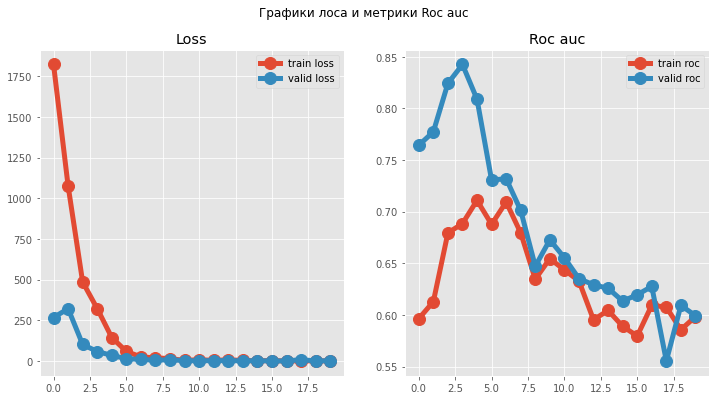

In [36]:
set_seed()
loss_train_e, loss_valid_e, f1_train_e, f1_valid_e = train(model, 
            train_loader, valid_loader, optimizer, criterion, device=device, n_epochs=20)
loss_train.extend(loss_train_e)
loss_valid.extend(loss_valid_e)
f1_train.extend(f1_train_e)
f1_valid.extend(f1_valid_e)

Макс значение метрики roc-auc - 0.85 на валидации, далее идет переобучение